# Creating a Depth Map using pretrained Transformers
Links:
- https://github.com/NielsRogge/Transformers-Tutorials/blob/master/DPT/DPT_inference_notebook_%28depth_estimation%29.ipynb
- https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Depth%20Anything/Predicting_depth_in_an_image_with_Depth_Anything.ipynb

In [24]:
!pip install opencv-python
!pip install cvlib
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 61.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for cvlib: filename=cvlib-0.2.7-py3-none-any.whl size=10046370 sha256=e06e12c5e200ac9e8c1ea8ccca5e830917f392456752e1fd6dbd3ea62e8d0f02
  Stored in directory: /root/.cache/pip/wheels/9e/a5/d4/fe37b48fe4f4b621ba5e574a991230070f3cc4f02322a01489
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12067 sha256=b44a2e06ed1c5393f36c62e1877893d8c7d55beb52247de08d1021ecbc4c9257
  Stored in directory: /root/.cache/pip/wheels/cd/17/e5/765d1a3112ff3978f70223502f6047e06c43a24d7c5f8ff95b
Successfully built cvlib progressbar
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Reading in Room Data
We'll flip through some Kaggle Data to demo the feature transformer depth map.

In [6]:
!apt install unzip
!unzip "/content/roomData.zip"

Streaming output truncated to the last 5000 lines.
  inflating: House_Room_Dataset/Bathroom/bath_325.jpg  
  inflating: House_Room_Dataset/Bathroom/bath_331.jpg  
  inflating: House_Room_Dataset/Bathroom/bath_333.jpg  
  inflating: House_Room_Dataset/Bathroom/bath_334.jpg  
  inflating: House_Room_Dataset/Bathroom/bath_336.jpg  
  inflating: House_Room_Dataset/Bathroom/bath_339.jpg  
  inflating: House_Room_Dataset/Bathroom/bath_34.jpg  
  inflating: House_Room_Dataset/Bathroom/bath_340.jpg  
  inflating: House_Room_Dataset/Bathroom/bath_341.jpg  
  inflating: House_Room_Dataset/Bathroom/bath_342.jpg  
  inflating: House_Room_Dataset/Bathroom/bath_343.jpg  
  inflating: House_Room_Dataset/Bathroom/bath_346.jpg  
  inflating: House_Room_Dataset/Bathroom/bath_348.jpg  
  inflating: House_Room_Dataset/Bathroom/bath_349.jpg  
  inflating: House_Room_Dataset/Bathroom/bath_350.jpg  
  inflating: House_Room_Dataset/Bathroom/bath_351.jpg  
  inflating: House_Room_Dataset/Bathroom/bath_354.jpg 

In [16]:
from PIL import Image
import os

directory = "House_Room_Dataset/Livingroom" # content/roomData

images = []
for root, dirs, files in os.walk(directory):
    for f in files:
        if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
            file_path = os.path.join(root, f)
            try:
                img = Image.open(file_path)
                images.append(img)
                # print(f"Loaded image: {file_path}")
            except IOError:
                print(f"Cannot open image: {file_path}")

print(f"Total images loaded: {len(images)}")

Total images loaded: 1273


### Preprocessing images for better feature extraction


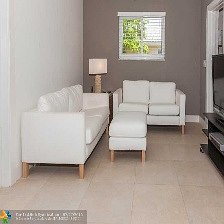

In [17]:
from PIL import Image, ImageEnhance, ImageFilter
import cv2
import numpy as np

def process_image(image):

    # # Enhance Sharpness
    enhancer = ImageEnhance.Sharpness(image)
    image_sharp = enhancer.enhance(1.5)  # Enhance sharpness by a factor of 2.0

    # image_np = np.array(image.convert('L'))  # Convert to grayscale

    # # Apply Histogram Equalization
    # equalized = cv2.equalizeHist(image_np)

    # # Convert equalized image back to PIL image
    # return_pil = Image.fromarray(equalized)

    return image_sharp

process_image(images[0])

In [18]:
allImgs = [process_image(image) for image in images]
images = allImgs[:15]

### Depth map computation

In [19]:
# loading models

# https://huggingface.co/Intel/dpt-beit-large-512 is the best model but also has ridiculous computation times

from transformers import AutoImageProcessor, AutoModelForDepthEstimation
import torch
import numpy as np

processor = AutoImageProcessor.from_pretrained("nielsr/depth-anything-small")
model = AutoModelForDepthEstimation.from_pretrained("nielsr/depth-anything-small")

In [20]:
# mainloop
import cv2

depths = []

percentCompleted = 0
percentInterval = 0.1

for i, image in enumerate(images):
    pixel_values = processor(images=image, return_tensors="pt").pixel_values

    with torch.no_grad():
        outputs = model(pixel_values)
        predicted_depth = outputs.predicted_depth

    h, w = image.size[::-1]

    # interpolation back from predictions to earlier size
    depth = torch.nn.functional.interpolate(predicted_depth[None], (h, w), mode='bilinear', align_corners=False)[0, 0]
    depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
    depth = depth.cpu().numpy().astype(np.uint8)
    colored_depth = cv2.applyColorMap(depth, cv2.COLORMAP_INFERNO)[:, :, ::-1]

    depths.append(Image.fromarray(colored_depth))

    if (len(depths) / len(images)) >= percentCompleted:
        print(f"{round(percentCompleted * 100)}% completed!")
        percentCompleted += percentInterval

0% completed!
10% completed!
20% completed!
30% completed!
40% completed!
50% completed!
60% completed!
70% completed!
80% completed!
90% completed!
100% completed!


In [21]:
# create images that display next to each other

def concatenate_images_horizontally(image_list):
    widths, heights = zip(*(img.size for img in image_list))

    total_width = sum(widths)
    max_height = max(heights)

    new_image = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for img in image_list:
        new_image.paste(img, (x_offset, 0))
        x_offset += img.width

    return new_image

imageAndDepths = [concatenate_images_horizontally([images[i], depths[i]]) for i in range(len(depths))]

In [22]:
import IPython.display as display
import ipywidgets as widgets
from ipywidgets import interact

# Function to display an image
def show_image(image):
    display.display(image)

# Function to update the displayed image
def update_image(index, imgs):
    display.clear_output(wait=True)
    show_image(imgs[index])

showThese = imageAndDepths

# Create an interactive slider
interact(lambda index: update_image(index, showThese), index=widgets.IntSlider(min=0, max=len(showThese)-1, step=1, value=0))

# image 11, 12, 14 are problem images

interactive(children=(IntSlider(value=0, description='index', max=14), Output()), _dom_classes=('widget-intera…

<function __main__.<lambda>(index)>

In [ ]:
# distance from DPT ?

### Object Detection Transformer

In [40]:
import cv2
import numpy as np
import cvlib as cv
from PIL import Image, ImageDraw, ImageFont
from cvlib.object_detection import draw_bbox
import matplotlib.pyplot as plt

In [41]:
objDetData = []
objDetImgs = []

# Load YOLO model
def load_yolo():
    net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
    with open("coco.names", "r") as f:
        classes = [line.strip() for line in f.readlines()]
    return net, classes, output_layers

# Process image through YOLO
def detect_objects(img, net, output_layers):
    height, width, channels = img.shape
    blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    class_ids = []
    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    return boxes, confidences, class_ids, indexes

# Draw bounding boxes on image
def draw_boxes(img, boxes, confidences, class_ids, indexes, classes):
    draw = ImageDraw.Draw(img)
    font = ImageFont.load_default()
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            confidence = confidences[i]
            color = (0, 0, 0)
            draw.rectangle([x, y, x + w, y + h], outline=color, width=2)
            draw.text((x, y - 10), f"{label} {confidence:.2f}", fill=color, font=font)
    return img


In [57]:
# Main function
def objectDetection(img, idx):
    # Load YOLO
    net, classes, output_layers = load_yolo()

    # Load image
    img_cv2 = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    # Detect objects
    boxes, confidences, class_ids, indexes = detect_objects(img_cv2, net, output_layers)

    # Draw bounding boxes
    img_with_boxes = draw_boxes(depths[idx], boxes, confidences, class_ids, indexes, classes)

    # Save and show result
    return (img_with_boxes, [boxes, confidences, [classes[class_id] for class_id in class_ids], indexes])

[[[9, 57, 102, 51], [5, 49, 107, 67], [7, 60, 105, 55], [3, 59, 113, 66], [167, 79, 57, 106], [169, 86, 54, 112], [0, 120, 132, 94], [5, 121, 136, 94], [7, 129, 133, 89], [134, 46, 38, 55]], [0.8078619837760925, 0.5246961116790771, 0.9374940991401672, 0.9327354431152344, 0.7253780364990234, 0.6943755149841309, 0.5072431564331055, 0.8506606817245483, 0.6455019116401672, 0.5751538872718811], ['sofa', 'sofa', 'sofa', 'sofa', 'chair', 'chair', 'sofa', 'sofa', 'chair', 'chair'], array([2, 7, 4, 9], dtype=int32)]


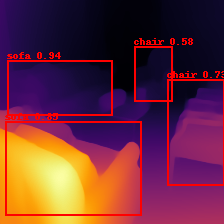

In [58]:
img_with_boxes, data = objectDetection(images[1], 1)
print(data)
img_with_boxes

### Functions to put it all together

In [59]:
fully_processed = [objectDetection(img, i) for i, img in enumerate(images)]
fully_processed[0]

(<PIL.Image.Image image mode=RGB size=224x224>,
 [[[9, 80, 103, 88]], [0.6732372045516968], ['sofa'], array([0], dtype=int32)])

In [62]:
import IPython.display as display
import ipywidgets as widgets
from ipywidgets import interact

# Function to display an image
def show_image(image):
    display.display(image)

# Function to update the displayed image
def update_image(index, imgs):
    display.clear_output(wait=True)
    show_image(imgs[index])

showThese = [concatenate_images_horizontally([images[i], data[0]]) for i, data in enumerate(fully_processed)]

# Create an interactive slider
interact(lambda index: update_image(index, showThese), index=widgets.IntSlider(min=0, max=len(showThese)-1, step=1, value=0))


interactive(children=(IntSlider(value=0, description='index', max=14), Output()), _dom_classes=('widget-intera…

<function __main__.<lambda>(index)>